## Import Packages

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set figure size for plots
rcParams['figure.figsize'] = 12, 6

## Data Preprocessing and Exploratory Analysis: Oil Pricing + USD Exchange Rates

In [40]:
data_file_path = '../data/preprocessed/merged_oil_exchange_full.csv'
preprocessed_data_dir_path = '../data/preprocessed'

In [41]:
def load_and_inspect_data(filepath):
    data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    data.sort_index(inplace=True)
    
    print("Dataset Shape:", data.shape)
    
    print("\nData Types:")
    print(data.dtypes)
    
    print("\nFirst 5 rows:")
    print(data.head())

    print("\Last 5 rows:")
    print(data.tail())
    
    print("\nMissing Values:")
    print(data.isnull().sum())
    
    print("\nBasic Statistics:")
    print(data.describe())
    
    return data

df = load_and_inspect_data(data_file_path)

Dataset Shape: (129, 2)

Data Types:
avg_oil_pricing      float64
usd_exchange_rate    float64
dtype: object

First 5 rows:
            avg_oil_pricing  usd_exchange_rate
date                                          
1990-08-14         12.95625             130.75
1990-11-05         16.41000             130.75
1990-12-26         14.63125             130.75
1991-01-01         14.61875             130.75
1992-05-13         14.74375             130.75
\Last 5 rows:
            avg_oil_pricing  usd_exchange_rate
date                                          
2023-09-01       280.000000           319.6472
2023-10-02       296.888889           323.5166
2023-11-01       302.666667           327.6173
2023-12-01       299.000000           327.5552
2024-01-01       309.222222           323.9902

Missing Values:
avg_oil_pricing      0
usd_exchange_rate    0
dtype: int64

Basic Statistics:
       avg_oil_pricing  usd_exchange_rate
count       129.000000         129.000000
mean        114.934816   

In [42]:
end_column = 'avg_oil_pricing'
exg_column = 'usd_exchange_rate'

In [44]:
def visualize_time_series(data, column_name):
    plt.figure(figsize=(14, 7))

    plt.plot(data[column_name])
    plt.title(f'Time Series: {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.grid(True)
    plt.show()

    # plot rolling mean and standard deviation
    rolling_mean = data[column_name].rolling(window=12).mean()
    rolling_std = data[column_name].rolling(window=12).std()
    plt.figure(figsize=(14, 7))
    plt.plot(data[column_name], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_std, label='Rolling Std', color='green')
    plt.title(f'Rolling Mean & Standard Deviation: {column_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

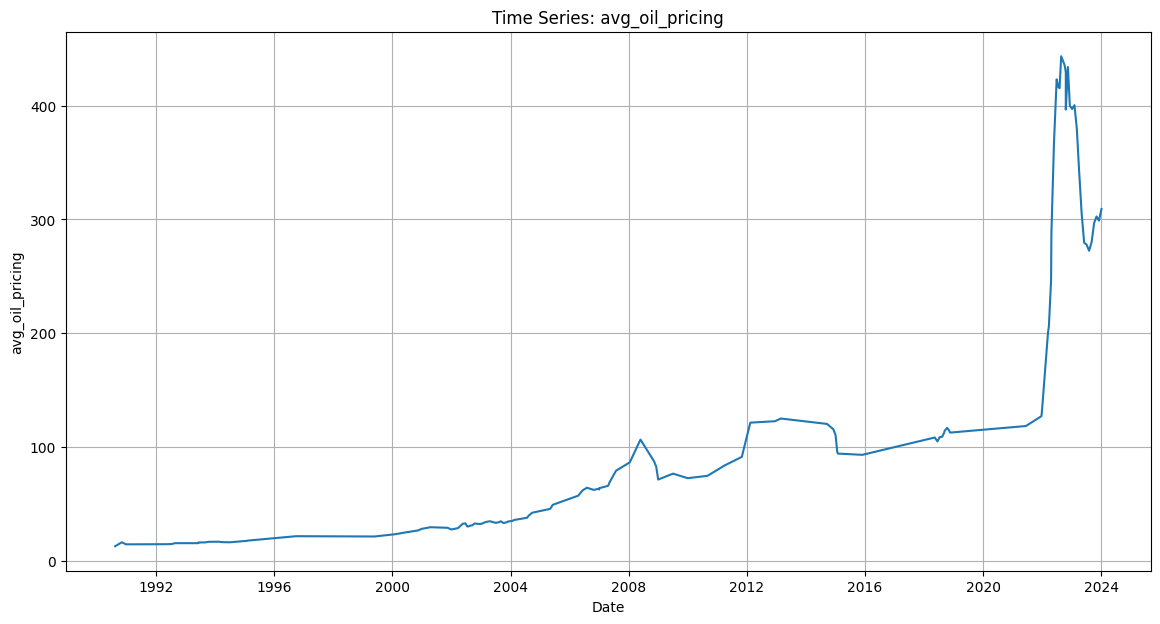

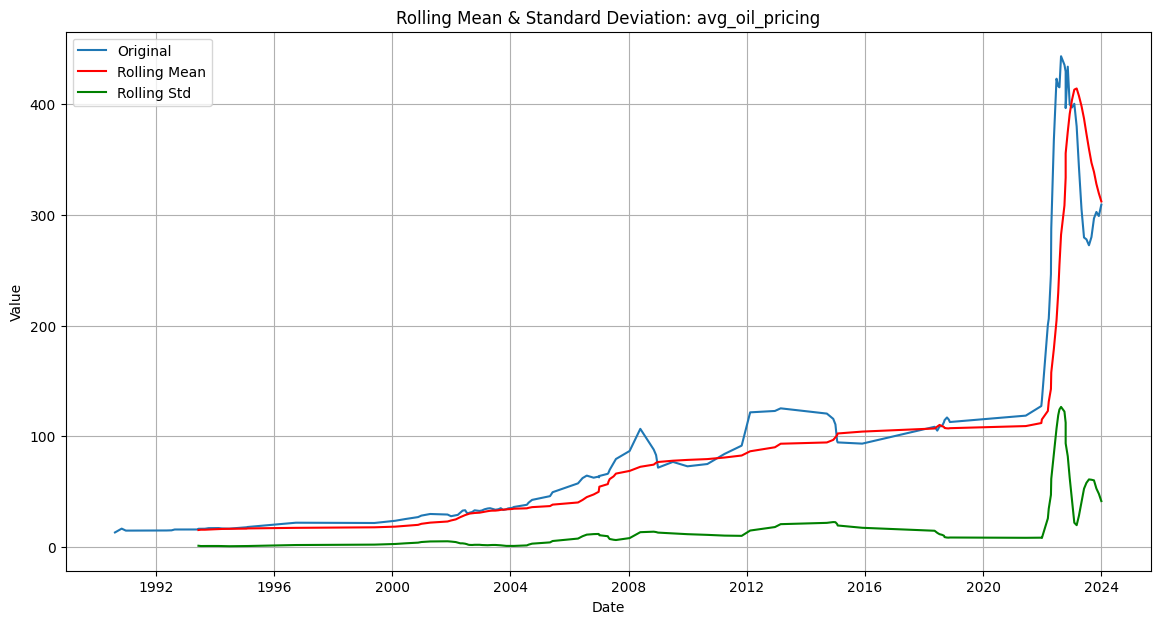

In [45]:
visualize_time_series(df, end_column)

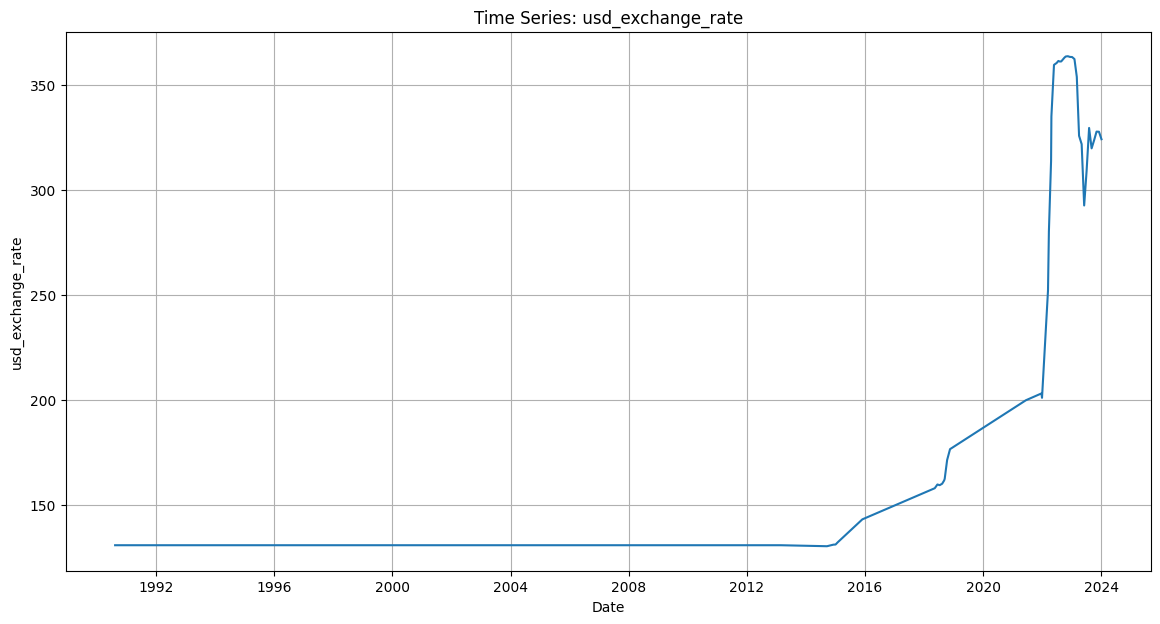

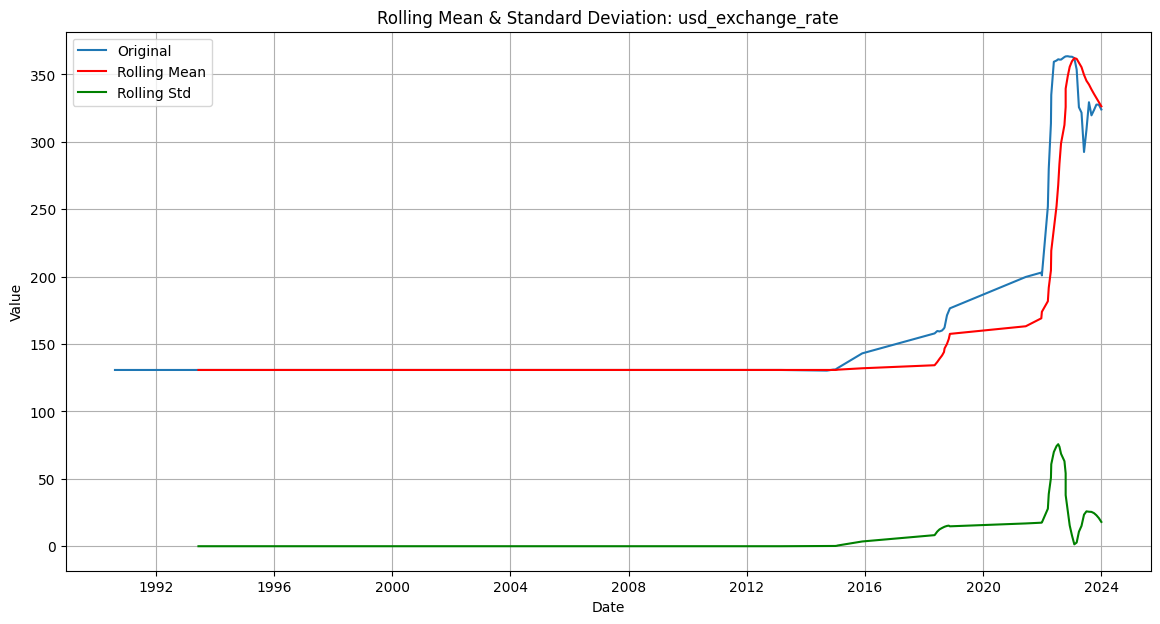

In [46]:
visualize_time_series(df, exg_column)

### Handle missing values and outliers within the Time Series

- **Forward fill**: refers to a method of imputation where values are replaced with the previous valid value in the dataset. This is also called as LOCF (Last Observation Carried Forward) <br><br>
- **Backward fill**: operates by replacing with the next valid value in the dataset (non missing value found in the dataset). <br><br>
- **Linear interpolation**: estimates missed values by assuming a liner relationship between data points: ```y = y1 + ((x - x1) / (x2 - x1)) * (y2 - y1)>``` <br><br>
- **Time-based interpolation**: estimates missed values by considering the temporal order of the data points. It leverages the relationship between data points at different time intervals to fill in the gaps, offering more accurate approach than simply using the mean or median

In [47]:
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print(f"Missing values before handling: {missing_values}")
    
    # Time-based interpolation
    data_time_interp = data.interpolate(method='time')
    missing_values = data_time_interp.isnull().sum()
    print(f"Missing values after handling: {missing_values}")
    return data_time_interp

data_missing_values_handled = handle_missing_values(df[end_column])

Missing values before handling: 0
Missing values after handling: 0


In [48]:
def handle_outliers(data, column_name, threshold=2, method='rolling_median'):
    data_clean = data.copy()
    
    original_data = data_clean[column_name].dropna()
    
    if len(original_data) == 0:
        print("No valid data points found!")
        return data_clean
    
    z_scores = np.abs(stats.zscore(original_data))
    outlier_mask = z_scores > threshold
    outlier_indices = original_data.index[outlier_mask]
    
    print(f"Outliers detected before handling: {len(outlier_indices)}")
    
    if len(outlier_indices) > 0:
        print(f"Outlier indices: {outlier_indices.tolist()}")
        print(f"Outlier values: {data_clean.loc[outlier_indices, column_name].values}")
        
        if method == 'rolling_median':
            rolling_median = data_clean[column_name].rolling(window=5, center=True, min_periods=1).median()
            rolling_median = rolling_median.fillna(data_clean[column_name].median())
            data_clean.loc[outlier_indices, column_name] = rolling_median.loc[outlier_indices]
            
        elif method == 'interpolation':
            temp_series = data_clean[column_name].copy()
            temp_series.loc[outlier_indices] = np.nan
            data_clean[column_name] = temp_series.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
            
        elif method == 'mean':
            rolling_mean = data_clean[column_name].rolling(window=5, center=True, min_periods=1).mean()
            rolling_mean = rolling_mean.fillna(data_clean[column_name].mean())
            data_clean.loc[outlier_indices, column_name] = rolling_mean.loc[outlier_indices]
            
        elif method == 'median':
            data_clean.loc[outlier_indices, column_name] = data_clean[column_name].median()
            
        elif method == 'clip':
            lower_bound = original_data.mean() - threshold * original_data.std()
            upper_bound = original_data.mean() + threshold * original_data.std()
            data_clean[column_name] = data_clean[column_name].clip(lower=lower_bound, upper=upper_bound)
    
    cleaned_data = data_clean[column_name].dropna()
    if len(cleaned_data) > 0:
        z_scores_after = np.abs(stats.zscore(cleaned_data))
        outliers_after = cleaned_data.index[z_scores_after > threshold]
        print(f"Outliers detected after handling: {len(outliers_after)}")
        
        if len(outliers_after) > 0:
            print(f"Remaining outlier indices: {outliers_after.tolist()}")
            print(f"Remaining outlier values: {data_clean.loc[outliers_after, column_name].values}")
    return data_clean

def compare_outlier_methods(data, column_name, threshold=2):
    methods = ['rolling_median', 'interpolation', 'mean', 'median', 'clip']
    results = {}
    
    print("=== COMPARING OUTLIER HANDLING METHODS ===\n")
    
    for method in methods:
        print(f"--- Method: {method.upper()} ---")
        cleaned_data = handle_outliers(data, column_name, threshold, method)
        
        original_std = data[column_name].std()
        cleaned_std = cleaned_data[column_name].std()
        
        results[method] = {
            'data': cleaned_data,
            'std_reduction': ((original_std - cleaned_std) / original_std) * 100,
            'mean_change': abs(data[column_name].mean() - cleaned_data[column_name].mean())
        }
        
        print(f"Standard deviation reduction: {results[method]['std_reduction']:.2f}%")
        print(f"Mean change: {results[method]['mean_change']:.4f}\n")
    
    return results

def visualize_outlier_handling(original_data, cleaned_data, column_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Time series plot
    axes[0, 0].plot(original_data.index, original_data[column_name], label='Original', alpha=0.7)
    axes[0, 0].plot(cleaned_data.index, cleaned_data[column_name], label='Cleaned', alpha=0.7)
    axes[0, 0].set_title('Time Series: Before vs After Outlier Handling')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Index')
    axes[0, 0].set_ylabel(column_name)
    
    # Box plots
    box_data = [original_data[column_name].dropna(), cleaned_data[column_name].dropna()]
    axes[0, 1].boxplot(box_data, labels=['Original', 'Cleaned'])
    axes[0, 1].set_title('Box Plot Comparison')
    axes[0, 1].set_ylabel(column_name)
    
    # Histograms
    axes[1, 0].hist(original_data[column_name].dropna(), alpha=0.7, label='Original', bins=30)
    axes[1, 0].hist(cleaned_data[column_name].dropna(), alpha=0.7, label='Cleaned', bins=30)
    axes[1, 0].set_title('Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel(column_name)
    axes[1, 0].set_ylabel('Frequency')
    
    # Z-score comparison
    z_original = np.abs(stats.zscore(original_data[column_name].dropna()))
    z_cleaned = np.abs(stats.zscore(cleaned_data[column_name].dropna()))
    
    axes[1, 1].scatter(range(len(z_original)), z_original, alpha=0.6, label='Original Z-scores')
    axes[1, 1].scatter(range(len(z_cleaned)), z_cleaned, alpha=0.6, label='Cleaned Z-scores')
    axes[1, 1].axhline(y=2, color='r', linestyle='--', label='Threshold (±2)')
    axes[1, 1].set_title('Z-scores Comparison')
    axes[1, 1].legend()
    axes[1, 1].set_xlabel('Data Point Index')
    axes[1, 1].set_ylabel('|Z-score|')
    
    plt.tight_layout()
    plt.show()

def outlier_handling(df, ts_column, threshold=2):
    print("=== OUTLIER HANDLING ===")
    print(f"Original data shape: {df.shape}")
    print(f"Original data statistics:")
    print(df[ts_column].describe())
    
    df_cleaned = handle_outliers(df, ts_column, threshold=threshold, method='rolling_median')
    
    print(f"\nCleaned data statistics:")
    print(df_cleaned[ts_column].describe())
    
    visualize_outlier_handling(df, df_cleaned, ts_column)
    return df, df_cleaned

=== OUTLIER HANDLING ===
Original data shape: (129, 2)
Original data statistics:
count    129.000000
mean     114.934816
std      126.474257
min       12.956250
25%       30.312500
50%       64.012500
75%      120.400000
max      443.444444
Name: avg_oil_pricing, dtype: float64
Outliers detected before handling: 13
Outlier indices: [Timestamp('2022-05-24 00:00:00'), Timestamp('2022-06-26 00:00:00'), Timestamp('2022-07-17 00:00:00'), Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-21 00:00:00'), Timestamp('2022-10-02 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-11-12 00:00:00'), Timestamp('2022-12-06 00:00:00'), Timestamp('2023-01-03 00:00:00'), Timestamp('2023-02-01 00:00:00'), Timestamp('2023-03-02 00:00:00')]
Outlier values: [367.55555556 423.11111111 416.44444444 415.33333333 443.44444444
 435.66666667 429.55555556 396.55555556 429.55555556 396.55555556
 434.         399.88888889 397.11111111 400.44444444 380.        ]
Outliers

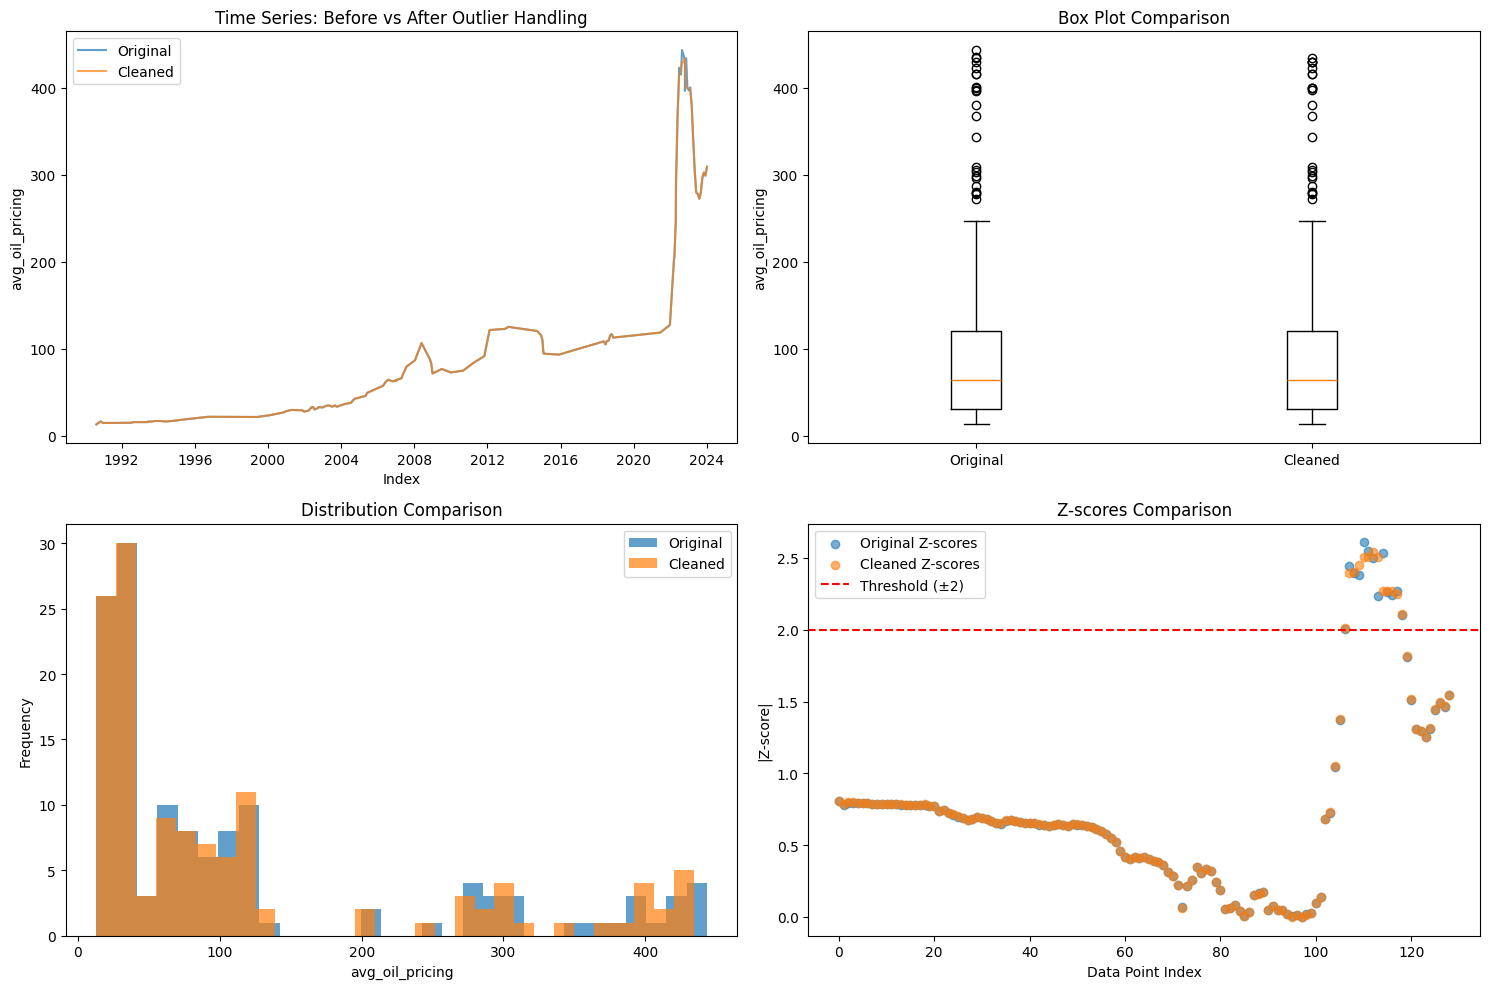

In [49]:
original_end_df, cleaned_end_df = outlier_handling(df, end_column)

=== OUTLIER HANDLING ===
Original data shape: (129, 2)
Original data statistics:
count    129.000000
mean     177.892921
std       83.961303
min      130.275900
25%      130.750000
50%      130.750000
75%      171.303400
max      363.500000
Name: usd_exchange_rate, dtype: float64
Outliers detected before handling: 13
Outlier indices: [Timestamp('2022-05-24 00:00:00'), Timestamp('2022-06-26 00:00:00'), Timestamp('2022-07-17 00:00:00'), Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-21 00:00:00'), Timestamp('2022-10-02 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-11-12 00:00:00'), Timestamp('2022-12-06 00:00:00'), Timestamp('2023-01-03 00:00:00'), Timestamp('2023-02-01 00:00:00'), Timestamp('2023-03-02 00:00:00')]
Outlier values: [359.3764 360.3    361.24   361.     361.     362.9    363.38   363.38
 363.38   363.38   363.5    363.18   363.11   362.14   353.6543]
Outliers detected after handling: 13
Remaining outlier indices: [Time

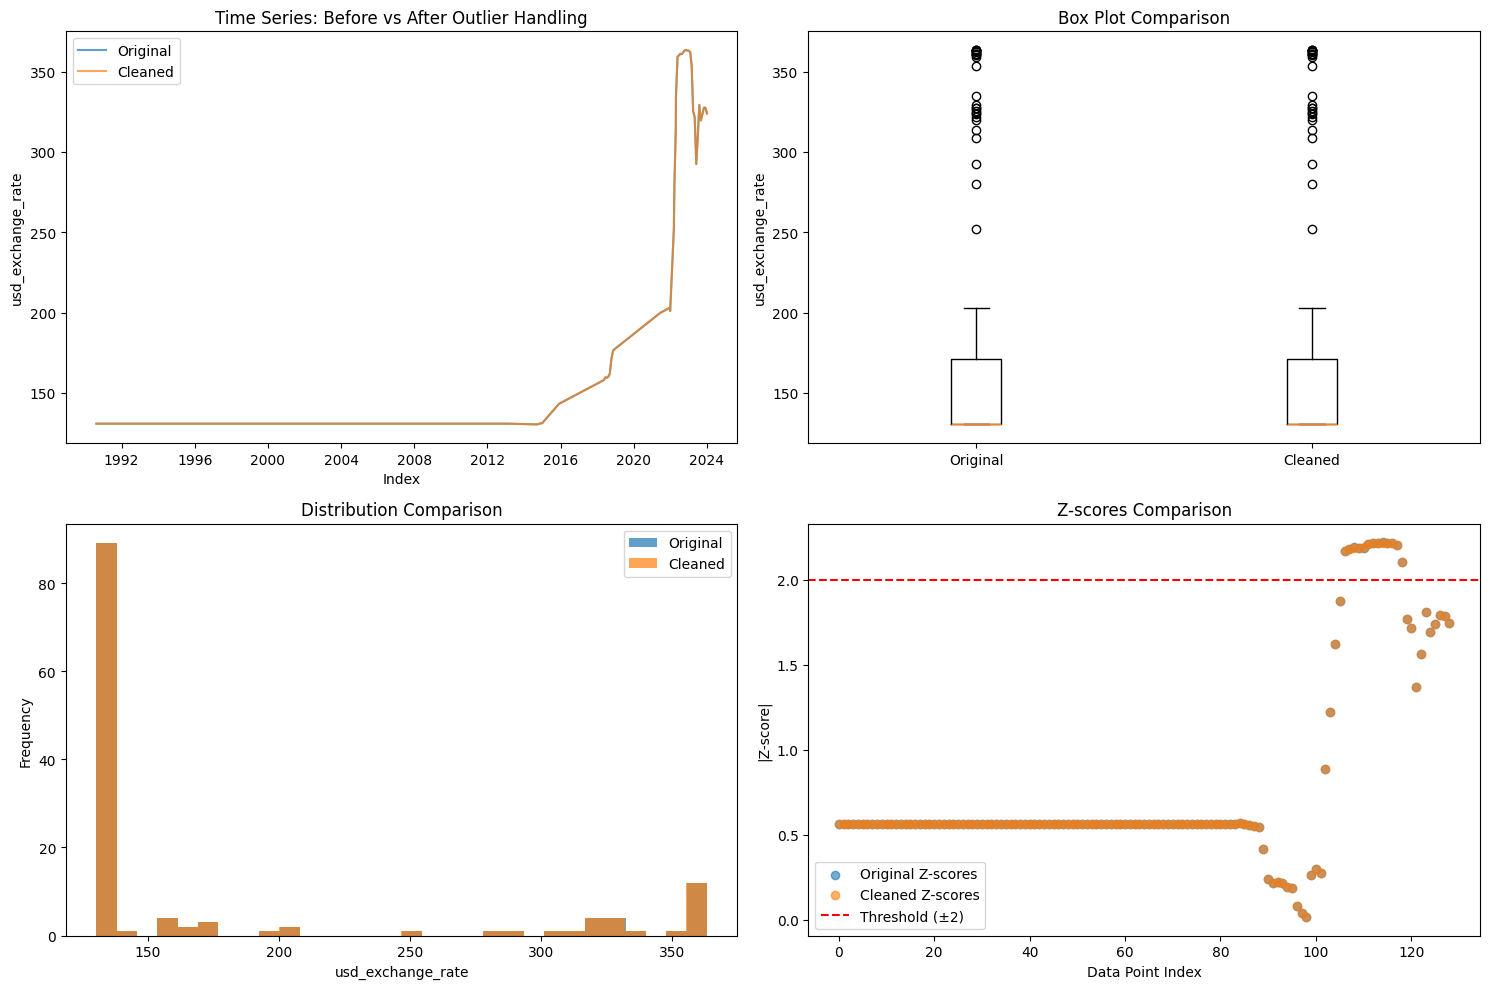

In [50]:
original_exg_df, cleaned_exg_df = outlier_handling(df, exg_column)

In [51]:
ts_end = cleaned_end_df.loc[:, end_column]
ts_exg = cleaned_exg_df.loc[:, exg_column]

In [52]:
ts_end.head()

date
1990-08-14    12.95625
1990-11-05    16.41000
1990-12-26    14.63125
1991-01-01    14.61875
1992-05-13    14.74375
Name: avg_oil_pricing, dtype: float64

In [53]:
ts_exg.head()

date
1990-08-14    130.75
1990-11-05    130.75
1990-12-26    130.75
1991-01-01    130.75
1992-05-13    130.75
Name: usd_exchange_rate, dtype: float64

### Stationary analysis of the Time Series
- ARIMA Hypothesis: provided time series is stationary where the time series has constant mean, variance, and autocovariance over time
- Dickey Fuller Test: evaluates whether the time series has a unit root, which implies the series is not stationary

In [54]:
def check_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        print(dfoutput)
    
    if dftest[1] <= 0.05:
        print("\nThe series is stationary (reject H0)")
    else:
        print("\nThe series is non-stationary (fail to reject H0)")

In [57]:
check_stationarity(ts_end)

Results of Dickey-Fuller Test:
Test Statistic                  -1.105055
p-value                          0.713052
#Lags Used                       2.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
dtype: float64
Test Statistic                  -1.105055
p-value                          0.713052
#Lags Used                       2.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
dtype: float64
Test Statistic                  -1.105055
p-value                          0.713052
#Lags Used                       2.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64

The series is non-stationary (fail to reject H0)


In [58]:
check_stationarity(ts_exg)

Results of Dickey-Fuller Test:
Test Statistic                  -0.916292
p-value                          0.782560
#Lags Used                       3.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
dtype: float64
Test Statistic                  -0.916292
p-value                          0.782560
#Lags Used                       3.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
dtype: float64
Test Statistic                  -0.916292
p-value                          0.782560
#Lags Used                       3.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64

The series is non-stationary (fail to reject H0)


In [59]:
def make_stationary(timeseries, seasonal_diff=None | int):
   # 1. Log transformation (reduces variance, handles exponential growth)
    if (timeseries > 0).all(): 
        ts_log = np.log(timeseries)
        plt.figure(figsize=(14, 5))
        plt.plot(ts_log, label='Log Transformed')
        plt.title('Log Transformation')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        ts_log = timeseries
        print("Skipping log transformation as data contains zero or negative values")

    # 2. Differencing (removes trend)
    ts_diff = ts_log.diff().dropna()
    plt.figure(figsize=(14, 5))
    plt.plot(ts_diff, label='Differenced')
    plt.title('Differenced Series (First Order)')
    plt.legend()
    plt.grid(True)
    plt.show()

    if seasonal_diff:
        # 3. Seasonal differencing (if applicable)
        # Example with 12 for monthly seasonality
        if len(ts_log) > 24: # Ensure enough data points
            ts_seasonal_diff = ts_log.diff(seasonal_diff).dropna()
            plt.figure(figsize=(14, 5))
            plt.plot(ts_seasonal_diff, label='Seasonally Differenced')
            plt.title(f'Seasonally Differenced Series (Difference: {seasonal_diff})')
            plt.legend()
            plt.grid(True)
            plt.show()
    # Check stationarity of transformed series
    print("\nStationarity check after first differencing:")
    check_stationarity(ts_diff)
    return ts_diff, ts_seasonal_diff

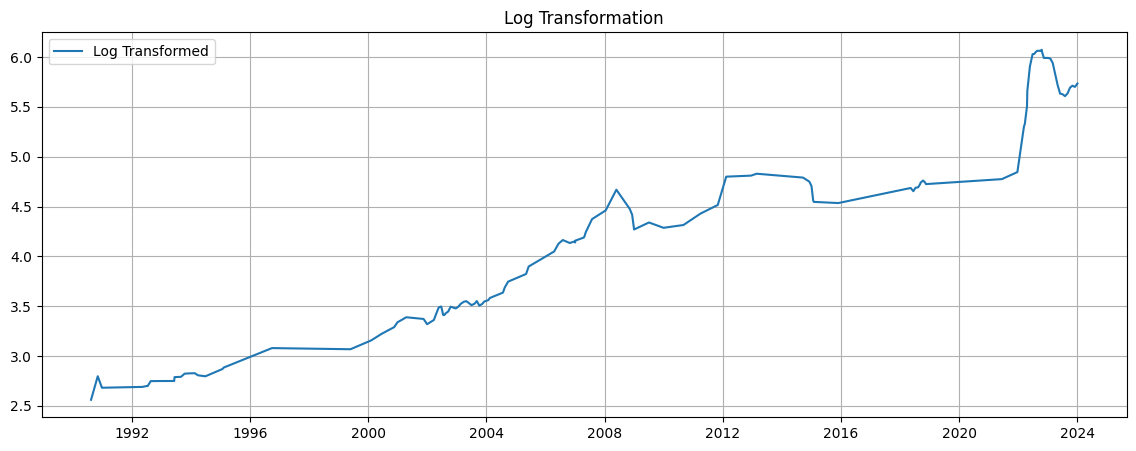

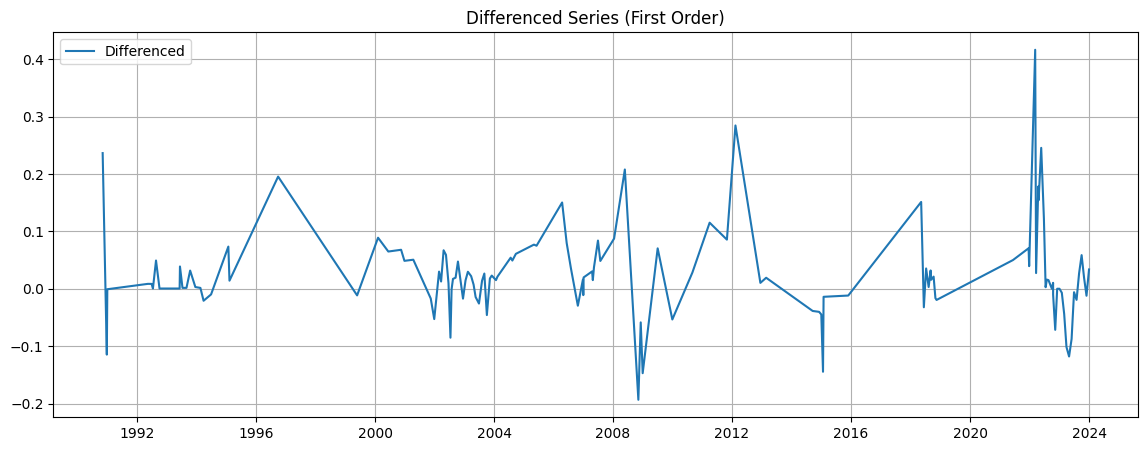

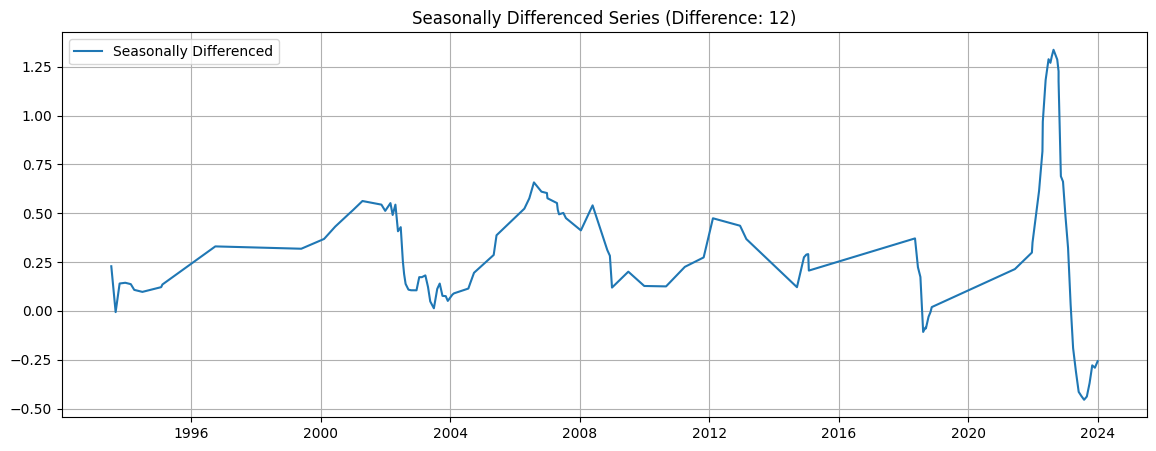


Stationarity check after first differencing:
Results of Dickey-Fuller Test:
Test Statistic                  -5.009918
p-value                          0.000021
#Lags Used                       1.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
dtype: float64
Test Statistic                  -5.009918
p-value                          0.000021
#Lags Used                       1.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
dtype: float64
Test Statistic                  -5.009918
p-value                          0.000021
#Lags Used                       1.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64

The series is stationary (reject H0)


In [60]:
ts_end_result = make_stationary(ts_end, seasonal_diff=12)
ts_end_diff, ts_end_seasonal_diff = ts_end_result[0], ts_end_result[1]

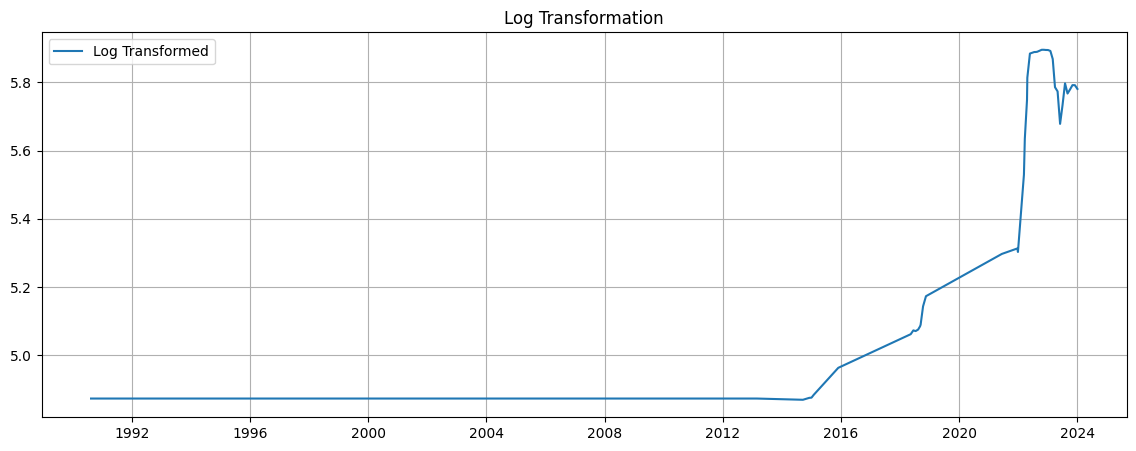

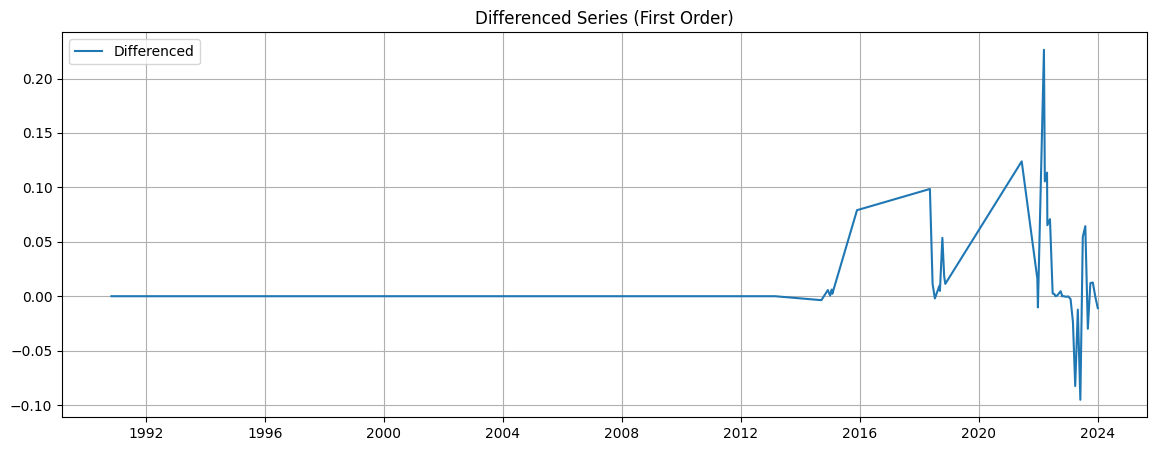

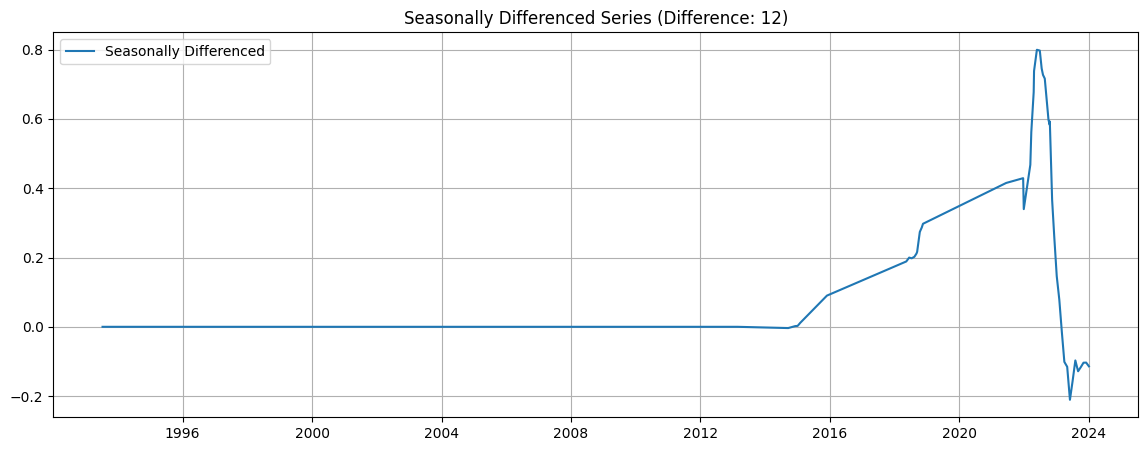


Stationarity check after first differencing:
Results of Dickey-Fuller Test:
Test Statistic                  -3.478210
p-value                          0.008565
#Lags Used                       2.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
dtype: float64
Test Statistic                  -3.478210
p-value                          0.008565
#Lags Used                       2.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
dtype: float64
Test Statistic                  -3.478210
p-value                          0.008565
#Lags Used                       2.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64

The series is stationary (reject H0)


In [61]:
ts_exg_result = make_stationary(ts_exg, seasonal_diff=12)
ts_exg_diff, ts_exg_seasonal_diff = ts_exg_result[0], ts_exg_result[1]

In [62]:
np.save(os.path.join(preprocessed_data_dir_path, 'end_diff.npy'), ts_end_diff)
np.save(os.path.join(preprocessed_data_dir_path, 'end_seasonal_diff.npy'), ts_end_seasonal_diff)
np.save(os.path.join(preprocessed_data_dir_path, 'exg_diff.npy'), ts_exg_diff)
np.save(os.path.join(preprocessed_data_dir_path, 'exg_seasonal_diff.npy'), ts_exg_seasonal_diff)